# (PyTorch) IMDB Dataset

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from tensorflow.contrib.keras.python.keras.datasets import imdb
from tensorflow.contrib.keras.python.keras.preprocessing import sequence
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.ticker as ticker

from yaringal_dataset import loader
from weight_drop import WeightDrop
from embed_regularize import embedded_dropout
from locked_dropout import LockedDropout

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (10, 5)

# Global params:
NB_WORDS = 20000
SKIP_TOP = 0
TEST_SPLIT = 0.2
INIT_SEED = 2017
GLOBAL_SEED = 2018
MAXLEN = 80
BATCH_SIZE = 128
TEST_BATCH_SIZE = 512

In [2]:
(X_train, Y_train), (X_test, Y_test) = imdb.load_data(num_words=NB_WORDS)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')
print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=MAXLEN)
X_test = sequence.pad_sequences(X_test, maxlen=MAXLEN)
print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)

25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


In [3]:
class Model(nn.Module):
    def __init__(self, nb_words, hidden_size=128, embedding_size=128, n_layers=1,
                 wdrop=0.25, odrop=0.25, edrop=0.1, idrop=0.25, variational=False,
                 standard_dropout=False, batch_first=True):
        super(Model, self).__init__()
        self.standard_dropout = standard_dropout
        self.lockdrop = LockedDropout(batch_first=batch_first)
        self.odrop = odrop
        self.idrop = idrop
        self.edrop = edrop
        self.n_layers = n_layers
        self.embedding = nn.Embedding(nb_words, embedding_size)
        self.rnns = [
            nn.LSTM(embedding_size if l == 0 else hidden_size,
                   hidden_size, num_layers=1, batch_first=batch_first)
            for l in range(n_layers)
        ]
        if wdrop:
            self.rnns = [WeightDrop(rnn, ['weight_hh_l0'], dropout=wdrop, variational=variational)
                         for rnn in self.rnns]
        self.rnns = torch.nn.ModuleList(self.rnns)
        self.output_layer = nn.Linear(hidden_size, 1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.output_layer.bias.data.fill_(0)
        self.output_layer.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, X):
        emb = embedded_dropout(self.embedding, X, dropout=self.edrop if self.training else 0)
        if self.standard_dropout:
            raw_output = F.dropout(emb, p=self.idrop, training=self.training)
        else:
            raw_output = self.lockdrop(emb, self.idrop)
        new_hidden, new_cell_state = [], []
        for l, rnn in enumerate(self.rnns):
            raw_output, (new_h, new_c) = rnn(raw_output)
            if self.standard_dropout:
                raw_output = F.dropout(raw_output, p=self.odrop, training=self.training)
            else:
                raw_output = self.lockdrop(raw_output, self.odrop)         
            new_hidden.append(new_h)
            new_cell_state.append(new_c)
        hidden = torch.cat(new_hidden, 0)
        cell_state = torch.cat(new_cell_state, 0)
        final_output = self.output_layer(raw_output)
        return final_output[:, -1, 0], hidden, cell_state

In [4]:
MC_ROUNDS = 10
def fit(model, optimizer, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor, n_epochs=30):
    epoch_losses = []
    criterion = torch.nn.BCEWithLogitsLoss()
    for epoch in range(n_epochs):
        indices = torch.randperm(len(X_train)).cuda()
        losses, acc = [], []
        model.train()
        for i in range(0, len(X_train), BATCH_SIZE): #tqdm_notebook(range(0, len(X_train), BATCH_SIZE)):
            optimizer.zero_grad()
            pred, _, _ = model(Variable(X_train_tensor[indices[i:(i+BATCH_SIZE)]]))
            # print(pred.size())
            loss = criterion(
                pred,
                Variable(Y_train_tensor[indices[i:(i+BATCH_SIZE)]], requires_grad=False)
            )
            acc.append(
                torch.eq(
                    (F.sigmoid(pred).data > 0.5).float(), 
                    Y_train_tensor[indices[i:(i+BATCH_SIZE)]]
                )
            )
            losses.append(loss.data.cpu()[0])
            loss.backward()
            optimizer.step()
        train_acc = torch.mean(torch.cat(acc).float())
        train_loss = np.mean(losses)
        # Standard dropout approximation
        losses, acc=[], []
        model.eval()    
        for i in range(0, len(X_test), TEST_BATCH_SIZE):
            pred_test, _, _ = model(Variable(X_test_tensor[i:(i+TEST_BATCH_SIZE)], volatile=True))
            # print(pred.size())
            loss = F.binary_cross_entropy_with_logits(
                pred_test, Variable(Y_test_tensor[i:(i+TEST_BATCH_SIZE)]))
            acc.append(
                torch.eq(
                    (F.sigmoid(pred_test).data > 0.5).float(), 
                    Y_test_tensor[i:(i+TEST_BATCH_SIZE)]
                )
            )
            losses.append(loss.data.cpu()[0])      
        std_test_acc = torch.mean(torch.cat(acc).float())
        std_test_loss = np.mean(losses)
        # MC dropout
        losses, acc = [], []
        model.train()
        for i in range(0, len(X_test), TEST_BATCH_SIZE):
            pred_list = []
            for j in range(MC_ROUNDS):
                pred_test, _, _ = model(Variable(X_test_tensor[i:(i+TEST_BATCH_SIZE)], volatile=True))
                pred_list.append(pred_test.unsqueeze(0))
            pred_all = torch.mean(torch.cat(pred_list, 0), 0)
            loss = F.binary_cross_entropy_with_logits(
                pred_all, Variable(Y_test_tensor[i:(i+TEST_BATCH_SIZE)]))
            acc.append(
                torch.eq(
                    (F.sigmoid(pred_all).data > 0.5).float(), 
                    Y_test_tensor[i:(i+TEST_BATCH_SIZE)]
                )
            )
            losses.append(loss.data.cpu()[0])      
        mc_test_acc = torch.mean(torch.cat(acc).float())            
        mc_test_loss = np.mean(losses)
        epoch_losses.append([
            train_loss, std_test_loss, mc_test_loss,
            train_acc, std_test_acc, mc_test_acc])
        print("Epoch: {} Train: {:.4f}/{:.2f}%, Val Std: {:.4f}/{:.2f}%, Val MC: {:.4f}/{:.2f}%".format(
            epoch, train_loss, train_acc*100, std_test_loss, std_test_acc*100, mc_test_loss, mc_test_acc*100))
    return epoch_losses

In [5]:
Y_train_tensor =  torch.from_numpy(Y_train).float().cuda()
Y_test_tensor =  torch.from_numpy(Y_test).float().cuda()
X_train_tensor =  torch.from_numpy(X_train).long().cuda()
X_test_tensor =  torch.from_numpy(X_test).long().cuda()

## Weight Dropped LSTM (w Embedding Dropout)

In [6]:
model_1 = Model(NB_WORDS, wdrop=0.02, odrop=0.1, edrop=0.2, idrop=0.1)
model_1.cuda()
optimizer = torch.optim.Adam([
            {'params': model_1.parameters(), 'lr': 1e-4, 'weight_decay': 1e-4}
        ])
epoch_losses_1 = fit(
    model_1, optimizer, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor, n_epochs=20)

Applying weight drop of 0.02 to weight_hh_l0


/home/ceshine/miniconda3/envs/ds36/lib/python3.6/site-packages/torch/nn/modules/module.py:224: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  result = self.forward(*input, **kwargs)


Epoch: 0 Train: 0.6924/52.88%, Val Std: 0.6914/57.39%, Val MC: 0.6914/56.94%
Epoch: 1 Train: 0.6778/59.19%, Val Std: 0.5747/72.48%, Val MC: 0.5808/72.26%
Epoch: 2 Train: 0.5012/76.00%, Val Std: 0.4284/80.82%, Val MC: 0.4335/80.31%
Epoch: 3 Train: 0.3891/82.96%, Val Std: 0.3726/83.60%, Val MC: 0.3784/83.21%
Epoch: 4 Train: 0.3391/85.58%, Val Std: 0.3595/84.21%, Val MC: 0.3646/84.01%
Epoch: 5 Train: 0.3100/87.06%, Val Std: 0.3621/84.08%, Val MC: 0.3662/83.84%
Epoch: 6 Train: 0.2871/88.10%, Val Std: 0.3478/84.58%, Val MC: 0.3519/84.40%
Epoch: 7 Train: 0.2709/88.95%, Val Std: 0.3632/84.30%, Val MC: 0.3661/84.10%
Epoch: 8 Train: 0.2551/89.70%, Val Std: 0.3680/83.89%, Val MC: 0.3701/83.60%
Epoch: 9 Train: 0.2420/90.23%, Val Std: 0.3654/84.05%, Val MC: 0.3676/84.00%
Epoch: 10 Train: 0.2279/90.86%, Val Std: 0.4208/82.69%, Val MC: 0.4191/82.53%
Epoch: 11 Train: 0.2254/91.06%, Val Std: 0.3681/83.99%, Val MC: 0.3699/83.67%
Epoch: 12 Train: 0.2103/91.61%, Val Std: 0.3709/83.93%, Val MC: 0.3732/83.

In [16]:
best_epoch = np.argmin([x[2] for x in epoch_losses_1]) + 1
print("Best Loss: {:.4f} Acc: {:.2f}% Best Epoch: {}".format(
    epoch_losses_1[best_epoch-1][2], 
    epoch_losses_1[best_epoch-1][5] * 100, 
    best_epoch
))

Best Loss: 0.3519 Acc: 84.40% Best Epoch: 7


## No Dropout

In [8]:
model_2 = Model(NB_WORDS, wdrop=0, odrop=0, edrop=0, idrop=0)
model_2.cuda()
optimizer = torch.optim.Adam(model_2.parameters(), lr=1e-4)
epoch_losses_2 = fit(model_2, optimizer, X_train_tensor, Y_train_tensor, 
                     X_test_tensor, Y_test_tensor, n_epochs=20)

Epoch: 0 Train: 0.6917/54.56%, Val Std: 0.6884/58.78%, Val MC: 0.6884/58.78%
Epoch: 1 Train: 0.5698/71.20%, Val Std: 0.4600/78.86%, Val MC: 0.4600/78.86%
Epoch: 2 Train: 0.3814/83.61%, Val Std: 0.3980/82.26%, Val MC: 0.3980/82.26%
Epoch: 3 Train: 0.3056/87.64%, Val Std: 0.3784/83.51%, Val MC: 0.3784/83.51%
Epoch: 4 Train: 0.2570/89.74%, Val Std: 0.3769/83.47%, Val MC: 0.3769/83.47%
Epoch: 5 Train: 0.2194/91.50%, Val Std: 0.4444/82.36%, Val MC: 0.4444/82.36%
Epoch: 6 Train: 0.1880/93.05%, Val Std: 0.4255/82.44%, Val MC: 0.4255/82.44%
Epoch: 7 Train: 0.1604/94.25%, Val Std: 0.4372/82.61%, Val MC: 0.4372/82.61%
Epoch: 8 Train: 0.1374/95.32%, Val Std: 0.5718/81.09%, Val MC: 0.5718/81.09%
Epoch: 9 Train: 0.1175/96.09%, Val Std: 0.5956/80.42%, Val MC: 0.5956/80.42%
Epoch: 10 Train: 0.0972/96.94%, Val Std: 0.5713/80.74%, Val MC: 0.5713/80.74%
Epoch: 11 Train: 0.0821/97.54%, Val Std: 0.6417/80.21%, Val MC: 0.6417/80.21%
Epoch: 12 Train: 0.0668/98.18%, Val Std: 0.7688/79.50%, Val MC: 0.7688/79.

In [9]:
best_epoch = np.argmin([x[1] for x in epoch_losses_2]) + 1
print("Best Loss: {:.4f} Acc: {:.2f}% Best Epoch: {}".format(
    epoch_losses_2[best_epoch-1][1], 
    epoch_losses_2[best_epoch-1][4] * 100, 
    best_epoch
))

Best Loss: 0.3769 Acc: 83.47% Best Epoch: 5


## Naive Dropout (w/o Embedding Dropout)

In [10]:
model_3 = Model(NB_WORDS, wdrop=0, odrop=0.2, edrop=0, idrop=0.2, standard_dropout=True)
model_3.cuda()
optimizer = torch.optim.Adam(model_3.parameters(), lr=1e-4)
epoch_losses_3 = fit(model_3, optimizer, X_train_tensor, Y_train_tensor, 
                     X_test_tensor, Y_test_tensor, n_epochs=20)

Epoch: 0 Train: 0.6923/53.21%, Val Std: 0.6907/58.68%, Val MC: 0.6908/58.40%
Epoch: 1 Train: 0.6259/66.89%, Val Std: 0.4936/77.11%, Val MC: 0.4942/77.01%
Epoch: 2 Train: 0.4230/81.03%, Val Std: 0.4094/82.35%, Val MC: 0.4097/82.25%
Epoch: 3 Train: 0.3392/85.78%, Val Std: 0.3897/82.91%, Val MC: 0.3906/82.88%
Epoch: 4 Train: 0.2950/88.06%, Val Std: 0.3768/83.31%, Val MC: 0.3772/83.30%
Epoch: 5 Train: 0.2580/89.38%, Val Std: 0.3761/83.62%, Val MC: 0.3766/83.65%
Epoch: 6 Train: 0.2314/90.55%, Val Std: 0.3864/83.57%, Val MC: 0.3862/83.52%
Epoch: 7 Train: 0.2070/91.93%, Val Std: 0.4045/83.09%, Val MC: 0.4034/82.91%
Epoch: 8 Train: 0.1904/92.57%, Val Std: 0.3861/83.26%, Val MC: 0.3862/83.23%
Epoch: 9 Train: 0.1694/93.73%, Val Std: 0.4203/82.62%, Val MC: 0.4178/82.54%
Epoch: 10 Train: 0.1613/94.02%, Val Std: 0.4137/82.86%, Val MC: 0.4129/82.76%
Epoch: 11 Train: 0.1441/94.74%, Val Std: 0.4727/81.91%, Val MC: 0.4680/82.03%
Epoch: 12 Train: 0.1363/95.12%, Val Std: 0.4851/82.16%, Val MC: 0.4803/82.

In [11]:
best_epoch = np.argmin([x[2] for x in epoch_losses_3]) + 1
print("Best Loss: {:.4f} Acc: {:.2f}% Best Epoch: {}".format(
    epoch_losses_3[best_epoch-1][2], 
    epoch_losses_3[best_epoch-1][5] * 100, 
    best_epoch
))

Best Loss: 0.3766 Acc: 83.65% Best Epoch: 6


## Variational LSTM

In [12]:
model_4 = Model(NB_WORDS, wdrop=0.02, odrop=0.1, edrop=0.2, idrop=0.1, variational=True)
model_4.cuda()
optimizer = torch.optim.Adam(model_4.parameters(), lr=1e-4)
epoch_losses_4 = fit(model_4, optimizer, X_train_tensor, Y_train_tensor, 
                     X_test_tensor, Y_test_tensor, n_epochs=20)

Applying weight drop of 0.02 to weight_hh_l0


/home/ceshine/miniconda3/envs/ds36/lib/python3.6/site-packages/torch/nn/modules/module.py:224: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  result = self.forward(*input, **kwargs)


Epoch: 0 Train: 0.6924/53.04%, Val Std: 0.6911/58.42%, Val MC: 0.6911/58.18%
Epoch: 1 Train: 0.6504/64.52%, Val Std: 0.5425/73.55%, Val MC: 0.5359/73.26%
Epoch: 2 Train: 0.4872/78.05%, Val Std: 0.4532/81.93%, Val MC: 0.4450/81.78%
Epoch: 3 Train: 0.4107/82.38%, Val Std: 0.3993/82.55%, Val MC: 0.3958/82.53%
Epoch: 4 Train: 0.3602/85.02%, Val Std: 0.3820/84.01%, Val MC: 0.3829/83.96%
Epoch: 5 Train: 0.3350/86.41%, Val Std: 0.3759/83.72%, Val MC: 0.3675/83.74%
Epoch: 6 Train: 0.3111/87.19%, Val Std: 0.3640/84.38%, Val MC: 0.3600/84.26%
Epoch: 7 Train: 0.2918/88.19%, Val Std: 0.3593/84.62%, Val MC: 0.3572/84.53%
Epoch: 8 Train: 0.2737/89.10%, Val Std: 0.3584/84.38%, Val MC: 0.3572/84.32%
Epoch: 9 Train: 0.2588/89.59%, Val Std: 0.3748/83.81%, Val MC: 0.3630/83.95%
Epoch: 10 Train: 0.2491/90.28%, Val Std: 0.3956/83.31%, Val MC: 0.3749/83.47%
Epoch: 11 Train: 0.2347/90.73%, Val Std: 0.3667/84.17%, Val MC: 0.3624/84.08%
Epoch: 12 Train: 0.2294/90.82%, Val Std: 0.4208/82.60%, Val MC: 0.3948/82.

In [13]:
best_epoch = np.argmin([x[2] for x in epoch_losses_4]) + 1
print("Best Loss: {:.4f} Acc: {:.2f}% Best Epoch: {}".format(
    epoch_losses_4[best_epoch-1][2], 
    epoch_losses_4[best_epoch-1][5] * 100, 
    best_epoch
))

Best Loss: 0.3572 Acc: 84.53% Best Epoch: 8


## Variational LSTM w/o Recurrent Dropout

In [14]:
model_5 = Model(NB_WORDS, wdrop=0., odrop=0.1, edrop=0.2, idrop=0.1)
model_5.cuda()
optimizer = torch.optim.Adam(model_5.parameters(), lr=1e-4)
epoch_losses_5= fit(model_5, optimizer, X_train_tensor, Y_train_tensor, 
                     X_test_tensor, Y_test_tensor, n_epochs=20)

Epoch: 0 Train: 0.6922/53.13%, Val Std: 0.6904/59.35%, Val MC: 0.6904/59.13%
Epoch: 1 Train: 0.6299/65.89%, Val Std: 0.4922/76.83%, Val MC: 0.4967/76.33%
Epoch: 2 Train: 0.4590/79.13%, Val Std: 0.4145/81.50%, Val MC: 0.4199/81.19%
Epoch: 3 Train: 0.3838/83.54%, Val Std: 0.3879/82.66%, Val MC: 0.3918/82.34%
Epoch: 4 Train: 0.3396/85.61%, Val Std: 0.3763/83.21%, Val MC: 0.3807/83.22%
Epoch: 5 Train: 0.3123/86.64%, Val Std: 0.3661/83.74%, Val MC: 0.3710/83.49%
Epoch: 6 Train: 0.2842/88.35%, Val Std: 0.3614/83.79%, Val MC: 0.3647/83.46%
Epoch: 7 Train: 0.2689/88.99%, Val Std: 0.3634/83.77%, Val MC: 0.3672/83.67%
Epoch: 8 Train: 0.2520/89.68%, Val Std: 0.3707/83.60%, Val MC: 0.3736/83.43%
Epoch: 9 Train: 0.2409/90.01%, Val Std: 0.3683/83.78%, Val MC: 0.3703/83.63%
Epoch: 10 Train: 0.2316/90.82%, Val Std: 0.3774/83.45%, Val MC: 0.3778/83.23%
Epoch: 11 Train: 0.2186/91.32%, Val Std: 0.3895/83.40%, Val MC: 0.3913/83.00%
Epoch: 12 Train: 0.2026/91.92%, Val Std: 0.4170/82.93%, Val MC: 0.4128/82.

In [17]:
best_epoch = np.argmin([x[2] for x in epoch_losses_5]) + 1
print("Best Loss: {:.4f} Acc: {:.2f}% Best Epoch: {}".format(
    epoch_losses_5[best_epoch-1][2], 
    epoch_losses_5[best_epoch-1][5] * 100, 
    best_epoch
))

Best Loss: 0.3647 Acc: 83.46% Best Epoch: 7


## Visualizations

(array([-0.04, -0.03, -0.02, -0.01,  0.  ,  0.01]),
 <a list of 6 Text xticklabel objects>)

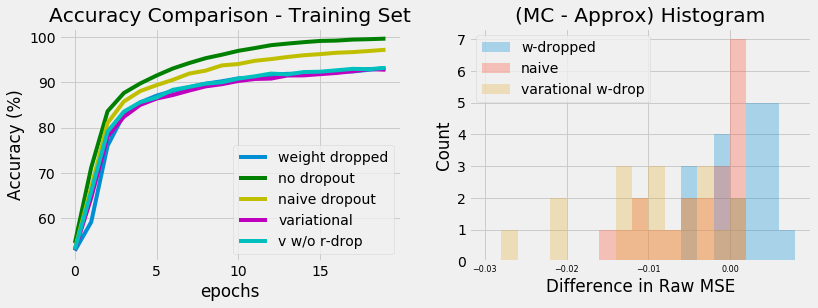

In [27]:
bins = np.arange(-0.03, 0.01, 0.002)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Accuracy Comparison - Training Set")
plt.plot(np.arange(len(epoch_losses_1)), [x[3] * 100 for x in epoch_losses_1], label="weight dropped")
plt.plot(np.arange(len(epoch_losses_2)), [x[3] * 100 for x in epoch_losses_2], "g-", label="no dropout")
plt.plot(np.arange(len(epoch_losses_3)), [x[3] * 100 for x in epoch_losses_3], "y-", label="naive dropout")
plt.plot(np.arange(len(epoch_losses_4)), [x[3] * 100 for x in epoch_losses_4], "m-", label="variational")
plt.plot(np.arange(len(epoch_losses_5)), [x[3] * 100 for x in epoch_losses_5], "c-", label="v w/o r-drop")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("Accuracy (%)")
plt.subplot(1, 2, 2)
plt.title("(MC - Approx) Histogram")
plt.hist([x[2] - x[1] for x in epoch_losses_1], bins=bins, alpha=0.3, label="w-dropped")
plt.hist([x[2] - x[1] for x in epoch_losses_3], bins=bins, alpha=0.3, label="naive")
plt.hist([x[2] - x[1] for x in epoch_losses_4], bins=bins, alpha=0.3, label="varational w-drop")
plt.legend(loc='best')
plt.xlabel("Difference in Raw MSE")
plt.ylabel("Count")
plt.xticks(fontsize=8, rotation=0)

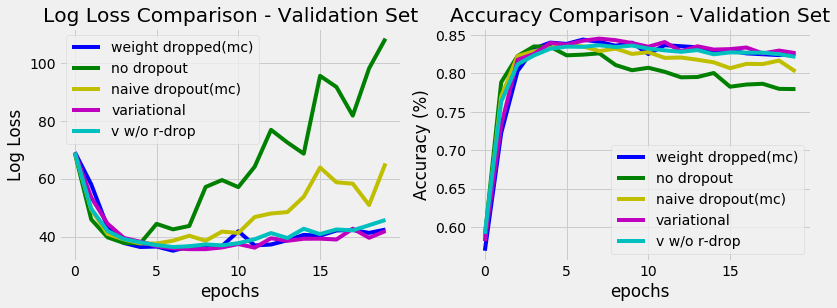

In [33]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Log Loss Comparison - Validation Set")
plt.plot(np.arange(len(epoch_losses_1)), [x[2] * 100 for x in epoch_losses_1], "b-", label="weight dropped(mc)")
plt.plot(np.arange(len(epoch_losses_2)), [x[2] * 100 for x in epoch_losses_2], "g-", label="no dropout")
plt.plot(np.arange(len(epoch_losses_3)), [x[2] * 100 for x in epoch_losses_3], "y-", label="naive dropout(mc)")
plt.plot(np.arange(len(epoch_losses_4)), [x[2] * 100 for x in epoch_losses_4], "m-", label="variational")
plt.plot(np.arange(len(epoch_losses_5)), [x[2] * 100 for x in epoch_losses_5], "c-", label="v w/o r-drop")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("Log Loss")
plt.subplot(1, 2, 2)
plt.title("Accuracy Comparison - Validation Set")
plt.plot(np.arange(len(epoch_losses_1)), [x[5] for x in epoch_losses_1], "b-", label="weight dropped(mc)")
plt.plot(np.arange(len(epoch_losses_2)), [x[5] for x in epoch_losses_2], "g-", label="no dropout")
plt.plot(np.arange(len(epoch_losses_3)), [x[5] for x in epoch_losses_3], "y-", label="naive dropout(mc)")
plt.plot(np.arange(len(epoch_losses_4)), [x[5] for x in epoch_losses_4], "m-", label="variational")
plt.plot(np.arange(len(epoch_losses_5)), [x[5] for x in epoch_losses_5], "c-", label="v w/o r-drop")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("Accuracy (%)")